### Data Ingestion

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
pd.set_option("display.max.columns", None)
import seaborn as sns
import numpy as np
import datetime
from sklearn.model_selection import train_test_split , cross_val_score , GridSearchCV , RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier 
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report , confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
import warnings
warnings.filterwarnings('ignore')

/Users/haitonghuang/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# How to read the data files in Python


users = pd.read_csv("https://s3.amazonaws.com/asana-data/takehome_project_users.csv")
user_engagement = pd.read_csv("https://s3.amazonaws.com/asana-data/takehome_project_user_engagement.csv", parse_dates = ['time_stamp'])


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  email_domain                12000 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 1.0+ MB


In [4]:
users.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
email_domain                     0
dtype: int64

In [5]:
user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [6]:
user_engagement.isnull().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

In [7]:
users = users.rename({'object_id' : 'user_id'}, axis = 1)

In [8]:
# Merge 2 tables 
# keep all users wheather they had engagement or not
# Count unique users

df = users.merge(user_engagement,on= 'user_id', how = 'left')

print(f"There are {len(df['user_id'].unique()):.0f} unique users in the whole data set")

There are 12000 unique users in the whole data set


In [9]:
# Double check the join

len(users['user_id'].unique())

12000

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211094 entries, 0 to 211093
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   user_id                     211094 non-null  int64         
 1   creation_time               211094 non-null  object        
 2   name                        211094 non-null  object        
 3   email                       211094 non-null  object        
 4   creation_source             211094 non-null  object        
 5   last_session_creation_time  207917 non-null  float64       
 6   opted_in_to_mailing_list    211094 non-null  int64         
 7   enabled_for_marketing_drip  211094 non-null  int64         
 8   org_id                      211094 non-null  int64         
 9   invited_by_user_id          118528 non-null  float64       
 10  email_domain                211094 non-null  object        
 11  time_stamp                  207917 non-

In [11]:
df.isnull().sum()

user_id                           0
creation_time                     0
name                              0
email                             0
creation_source                   0
last_session_creation_time     3177
opted_in_to_mailing_list          0
enabled_for_marketing_drip        0
org_id                            0
invited_by_user_id            92566
email_domain                      0
time_stamp                     3177
visited                        3177
dtype: int64

In [12]:
# assuming users have nulls in column invited_by_user_id are not invited to the app

df['last_session_creation_time'].fillna(0, inplace = True)
df['invited_by_user_id'].fillna(0, inplace = True)

In [13]:
df.describe()

,user_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited
count,211094.000000,2.110940e+05,211094.000000,211094.000000,211094.000000,211094.000000,207917.0
mean,5913.818777,1.378378e+09,0.257890,0.154344,163.949558,3352.867438,1.0
std,3395.988763,1.705843e+08,0.437474,0.361279,121.240661,3834.712022,0.0
min,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.0
25%,3081.000000,1.401013e+09,0.000000,0.000000,60.000000,0.000000,1.0
50%,5685.000000,1.401645e+09,0.000000,0.000000,145.000000,1579.000000,1.0
75%,8944.000000,1.401866e+09,1.000000,0.000000,260.000000,6442.000000,1.0
max,12000.000000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000,1.0


In [14]:
# to investigate null values

df[df.isna().any(axis=1)].head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain,time_stamp,visited
20,8,7/31/13 5:34,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,0.0,1,1,74,0.0,yahoo.com,NaT,NaN
21,9,11/5/13 4:04,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,0.0,0,0,302,0.0,hotmail.com,NaT,NaN
307,12,4/17/14 23:48,Mathiesen LÊrke,LaerkeLMathiesen@cuvox.de,ORG_INVITE,0.0,0,0,130,9270.0,cuvox.de,NaT,NaN
310,15,7/16/13 21:33,Theiss Ralf,RalfTheiss@hotmail.com,PERSONAL_PROJECTS,0.0,0,0,175,0.0,hotmail.com,NaT,NaN
311,16,2/11/13 10:09,Engel RenÈ,ReneEngel@hotmail.com,PERSONAL_PROJECTS,0.0,0,0,211,0.0,hotmail.com,NaT,NaN


In [15]:
# By randomly checking the users who contains nulls in time_stamp and visited, they are all inactive users I'll just drop them all

df = df.dropna()

In [16]:
# Now we have 8823 unique users in our data set

len(df['user_id'].unique())

8823

In [17]:
# see the time range with in the data set

df['time_stamp'].min(),df['time_stamp'].max(),df['time_stamp'].median()

(Timestamp('2012-05-31 08:20:06'),
 Timestamp('2014-06-06 14:58:50'),
 Timestamp('2013-12-03 06:38:34'))

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 211093
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   user_id                     207917 non-null  int64         
 1   creation_time               207917 non-null  object        
 2   name                        207917 non-null  object        
 3   email                       207917 non-null  object        
 4   creation_source             207917 non-null  object        
 5   last_session_creation_time  207917 non-null  float64       
 6   opted_in_to_mailing_list    207917 non-null  int64         
 7   enabled_for_marketing_drip  207917 non-null  int64         
 8   org_id                      207917 non-null  int64         
 9   invited_by_user_id          207917 non-null  float64       
 10  email_domain                207917 non-null  object        
 11  time_stamp                  207917 non-

In [19]:
# change all time series column into datetime data type

df['creation_time'] = pd.to_datetime(df['creation_time'])
df['last_session_creation_time'] = df['last_session_creation_time'].apply(datetime.datetime.utcfromtimestamp)
df['day'] = df['time_stamp'].dt.floor('d')

In [20]:
df.columns

Index(['user_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'email_domain', 'time_stamp', 'visited', 'day'],
      dtype='object')

### 1) Calculating Adoption Rate

In [21]:
# find unique_adopted_users 

rolling_count = pd.DataFrame(df.set_index('day').groupby('user_id')['user_id'].rolling('7D').count()).rename({'user_id':'rolling_count'}, axis = 1)
rolling_count = rolling_count.reset_index()
adopted_users = rolling_count[rolling_count['rolling_count'] >= 3]



print(f"\nThere are {len(adopted_users['user_id'].unique())} unique adopted users")


There are 1602 unique adopted users


In [22]:
# to calculate the adoption rate

adoption_rate = len(adopted_users['user_id'].unique()) / len(users['user_id'].unique())

print(f"The adoption_rate from the given dataset is: {adoption_rate * 100:.3f}% assuming the total users is the total unique users from the users table\n",'--'*70)

The adoption_rate from the given dataset is: 13.350% assuming the total users is the total unique users from the users table
 --------------------------------------------------------------------------------------------------------------------------------------------


In [23]:
# double check we have to right number of adopted users by using the orginal timestamp with a slightly different method

def rolling_count(df, number):
    return df.rolling(number, on='time_stamp')['user_id'].count()

df['visit_in_7_days'] = df.groupby('user_id', as_index=False, group_keys=False).apply(rolling_count, '7D')
users_more_than_3 = df[df['visit_in_7_days'] >= 3]
len(users_more_than_3['user_id'].unique())

1602

In [24]:
# mapping adopted_user 1:yes 0:no

df = df.merge(adopted_users, on= 'user_id', how = 'left').drop_duplicates(subset=['user_id'], keep='last')
df['adopted_user'] = df['rolling_count'].apply(lambda x: 1 if x>=3 else 0)

In [25]:
len(df.loc[df['adopted_user'] == 1]['user_id'].unique()),len(df.loc[df['adopted_user'] == 0]['user_id'].unique())

(1602, 7221)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 47503818
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     8823 non-null   int64         
 1   creation_time               8823 non-null   datetime64[ns]
 2   name                        8823 non-null   object        
 3   email                       8823 non-null   object        
 4   creation_source             8823 non-null   object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    8823 non-null   int64         
 7   enabled_for_marketing_drip  8823 non-null   int64         
 8   org_id                      8823 non-null   int64         
 9   invited_by_user_id          8823 non-null   float64       
 10  email_domain                8823 non-null   object        
 11  time_stamp                  8823 non-null   datetime

### 2) Methodology

In [27]:
df_model = df

In [28]:
df_model['creation_source'].value_counts()

ORG_INVITE            3188
SIGNUP                1898
GUEST_INVITE          1588
SIGNUP_GOOGLE_AUTH    1385
PERSONAL_PROJECTS      764
Name: creation_source, dtype: int64

In [29]:
df_model['opted_in_to_mailing_list'].value_counts()

0    6597
1    2226
Name: opted_in_to_mailing_list, dtype: int64

In [30]:
df_model['enabled_for_marketing_drip'].value_counts()

0    7482
1    1341
Name: enabled_for_marketing_drip, dtype: int64

In [31]:
df_model['invited_by_user_id'].value_counts()

0.0        4047
4612.0       10
11770.0       9
2308.0        9
730.0         8
           ... 
6455.0        1
3689.0        1
1255.0        1
6420.0        1
5093.0        1
Name: invited_by_user_id, Length: 2230, dtype: int64

In [32]:
df_model['email_domain'].value_counts().head(25)

gmail.com         2930
yahoo.com         1726
jourrapide.com     883
gustr.com          842
cuvox.de           828
hotmail.com        803
luque.com            2
mumdc.com            2
oqpze.com            2
xybhi.com            2
xvnbr.com            2
tgaim.com            1
yhnuj.com            1
upqhn.com            1
mngrr.com            1
gctmd.com            1
ceqro.com            1
vkjsm.com            1
kbaxq.com            1
eqtvz.com            1
jyspz.com            1
dshis.com            1
hfbri.com            1
eznoh.com            1
nqnui.com            1
Name: email_domain, dtype: int64

In [33]:
df_model['visited'].value_counts()

1.0    8823
Name: visited, dtype: int64

In [34]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 47503818
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     8823 non-null   int64         
 1   creation_time               8823 non-null   datetime64[ns]
 2   name                        8823 non-null   object        
 3   email                       8823 non-null   object        
 4   creation_source             8823 non-null   object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    8823 non-null   int64         
 7   enabled_for_marketing_drip  8823 non-null   int64         
 8   org_id                      8823 non-null   int64         
 9   invited_by_user_id          8823 non-null   float64       
 10  email_domain                8823 non-null   object        
 11  time_stamp                  8823 non-null   datetime

In [38]:
df_model = df_model.reset_index().drop(['index'],axis =1)

In [40]:
df_model

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain,time_stamp,visited,day_x,visit_in_7_days,rolling_count,adopted_user
0,1,2014-04-22 03:53:00,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,yahoo.com,2014-04-22 03:53:30,1.0,2014-04-22,1.0,NaN,0
1,2,2013-11-15 03:45:00,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,gustr.com,2014-03-31 03:45:04,1.0,2014-03-31,1.0,3.0,1
2,3,2013-03-19 23:14:00,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,gustr.com,2013-03-19 23:14:52,1.0,2013-03-19,1.0,NaN,0
3,4,2013-05-21 08:09:00,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,yahoo.com,2013-05-22 08:09:28,1.0,2013-05-22,1.0,NaN,0
4,5,2013-01-17 10:14:00,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,yahoo.com,2013-01-22 10:14:20,1.0,2013-01-22,1.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8818,11996,2013-09-06 06:14:00,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0,gustr.com,2013-09-06 06:14:15,1.0,2013-09-06,1.0,NaN,0
8819,11997,2013-01-10 18:28:00,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,0.0,gmail.com,2013-01-15 18:28:37,1.0,2013-01-15,1.0,NaN,0
8820,11998,2014-04-27 12:45:00,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0,cuvox.de,2014-04-27 12:45:16,1.0,2014-04-27,1.0,NaN,0
8821,11999,2012-05-31 11:55:00,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,0.0,iuxiw.com,2012-06-02 11:55:59,1.0,2012-06-02,1.0,NaN,0


In [43]:
# one hot encoding creation_source

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False,drop = 'first')

creation_sourcedf = pd.DataFrame(encoder.fit_transform(df_model['creation_source'].array.reshape(-1,1)), columns=encoder.get_feature_names_out(['creation_source']))

df_model = pd.concat([df_model,creation_sourcedf], axis =1)
df_model.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain,time_stamp,visited,day_x,visit_in_7_days,rolling_count,adopted_user,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:00,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,yahoo.com,2014-04-22 03:53:30,1.0,2014-04-22,1.0,NaN,0,0.0,0.0,0.0,0.0
1,2,2013-11-15 03:45:00,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,gustr.com,2014-03-31 03:45:04,1.0,2014-03-31,1.0,3.0,1,1.0,0.0,0.0,0.0
2,3,2013-03-19 23:14:00,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,gustr.com,2013-03-19 23:14:52,1.0,2013-03-19,1.0,NaN,0,1.0,0.0,0.0,0.0
3,4,2013-05-21 08:09:00,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,yahoo.com,2013-05-22 08:09:28,1.0,2013-05-22,1.0,NaN,0,0.0,0.0,0.0,0.0
4,5,2013-01-17 10:14:00,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,yahoo.com,2013-01-22 10:14:20,1.0,2013-01-22,1.0,NaN,0,0.0,0.0,0.0,0.0


In [44]:
df_model['email_domain'].value_counts().head(20)

gmail.com         2930
yahoo.com         1726
jourrapide.com     883
gustr.com          842
cuvox.de           828
hotmail.com        803
luque.com            2
mumdc.com            2
oqpze.com            2
xybhi.com            2
xvnbr.com            2
tgaim.com            1
yhnuj.com            1
upqhn.com            1
mngrr.com            1
gctmd.com            1
ceqro.com            1
vkjsm.com            1
kbaxq.com            1
eqtvz.com            1
Name: email_domain, dtype: int64

In [45]:
# lookback to the value_counts before for email_domains, only gmail,yahoo,hotmail,jourrapid,gustr,cuvox are the real email service
# providers, so here I will delete the rest ones since they are fake one.

domain = ['gmail.com','yahoo.com','hotmail.com','jourrapide.com','gustr.com','cuvox.de']

df_model = df_model[df_model['email_domain'].isin(domain)]
df_model = df_model.reset_index()

In [46]:
df_model['email_domain'].value_counts()

gmail.com         2930
yahoo.com         1726
jourrapide.com     883
gustr.com          842
cuvox.de           828
hotmail.com        803
Name: email_domain, dtype: int64

In [47]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8012 entries, 0 to 8011
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   index                               8012 non-null   int64         
 1   user_id                             8012 non-null   int64         
 2   creation_time                       8012 non-null   datetime64[ns]
 3   name                                8012 non-null   object        
 4   email                               8012 non-null   object        
 5   creation_source                     8012 non-null   object        
 6   last_session_creation_time          8012 non-null   datetime64[ns]
 7   opted_in_to_mailing_list            8012 non-null   int64         
 8   enabled_for_marketing_drip          8012 non-null   int64         
 9   org_id                              8012 non-null   int64         
 10  invited_by_user_id      

In [50]:
# one hot encoding email_domain


email_domaindf = pd.DataFrame(encoder.fit_transform(df_model['email_domain'].array.reshape(-1,1)), columns=encoder.get_feature_names_out(['email_domain']))

df_model = pd.concat([df_model,email_domaindf], axis =1)
df_model.head()

,index,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain,time_stamp,visited,day_x,visit_in_7_days,rolling_count,adopted_user,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,email_domain_gmail.com,email_domain_gustr.com,email_domain_hotmail.com,email_domain_jourrapide.com,email_domain_yahoo.com
0,0,1,2014-04-22 03:53:00,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,yahoo.com,2014-04-22 03:53:30,1.0,2014-04-22,1.0,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,2,2013-11-15 03:45:00,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,gustr.com,2014-03-31 03:45:04,1.0,2014-03-31,1.0,3.0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,3,2013-03-19 23:14:00,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,gustr.com,2013-03-19 23:14:52,1.0,2013-03-19,1.0,NaN,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3,4,2013-05-21 08:09:00,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,yahoo.com,2013-05-22 08:09:28,1.0,2013-05-22,1.0,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,5,2013-01-17 10:14:00,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,yahoo.com,2013-01-22 10:14:20,1.0,2013-01-22,1.0,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [51]:
df_model['invited_by_user_id'].value_counts()

0.0        3749
4612.0       10
11770.0       9
730.0         8
3721.0        8
           ... 
274.0         1
7554.0        1
11040.0       1
5521.0        1
5093.0        1
Name: invited_by_user_id, Length: 2101, dtype: int64

In [52]:
df_model = df_model.reset_index()

In [53]:
# creating a new column is_invited 1 = Yes, 0 = No

df_model['is_invited'] = df_model['invited_by_user_id'].apply(lambda x: 0 if x==0 else 1)

In [54]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8012 entries, 0 to 8011
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   level_0                             8012 non-null   int64         
 1   index                               8012 non-null   int64         
 2   user_id                             8012 non-null   int64         
 3   creation_time                       8012 non-null   datetime64[ns]
 4   name                                8012 non-null   object        
 5   email                               8012 non-null   object        
 6   creation_source                     8012 non-null   object        
 7   last_session_creation_time          8012 non-null   datetime64[ns]
 8   opted_in_to_mailing_list            8012 non-null   int64         
 9   enabled_for_marketing_drip          8012 non-null   int64         
 10  org_id                  

In [55]:
df_model = df_model.drop(['level_0','index'], axis =1 )

In [56]:
# intuitively I think the user length between last session and account creation_time can be a good indepentdent feature

df_model['user_length'] = df_model['last_session_creation_time'].sub(df_model['creation_time'], axis=0).dt.days

In [57]:
df_model['adopted_user'].value_counts()

0    6567
1    1445
Name: adopted_user, dtype: int64

In [58]:
df_model.columns

Index(['user_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'email_domain', 'time_stamp', 'visited', 'day_x', 'visit_in_7_days',
       'rolling_count', 'adopted_user', 'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH', 'email_domain_gmail.com',
       'email_domain_gustr.com', 'email_domain_hotmail.com',
       'email_domain_jourrapide.com', 'email_domain_yahoo.com', 'is_invited',
       'user_length'],
      dtype='object')

In [59]:
# now drop the columns we don't need

drop_columns = ['creation_time','user_id','name','email','creation_source','last_session_creation_time','invited_by_user_id','email_domain','time_stamp','day_x','visit_in_7_days','rolling_count','visited']

df_model = df_model.drop(drop_columns, axis = 1)

In [60]:
df_model.isnull().sum()

opted_in_to_mailing_list              0
enabled_for_marketing_drip            0
org_id                                0
adopted_user                          0
creation_source_ORG_INVITE            0
creation_source_PERSONAL_PROJECTS     0
creation_source_SIGNUP                0
creation_source_SIGNUP_GOOGLE_AUTH    0
email_domain_gmail.com                0
email_domain_gustr.com                0
email_domain_hotmail.com              0
email_domain_jourrapide.com           0
email_domain_yahoo.com                0
is_invited                            0
user_length                           0
dtype: int64

In [61]:
df_model.rename(columns=''.join, inplace=True)
df_model

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,email_domain_gmail.com,email_domain_gustr.com,email_domain_hotmail.com,email_domain_jourrapide.com,email_domain_yahoo.com,is_invited,user_length
0,1,0,11,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0
1,0,0,1,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,136
2,0,0,94,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
3,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1
4,0,0,193,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8007,0,0,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1
8008,0,0,89,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
8009,0,0,200,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,5
8010,1,1,83,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


In [62]:
df_model['adopted_user'].value_counts()

0    6567
1    1445
Name: adopted_user, dtype: int64

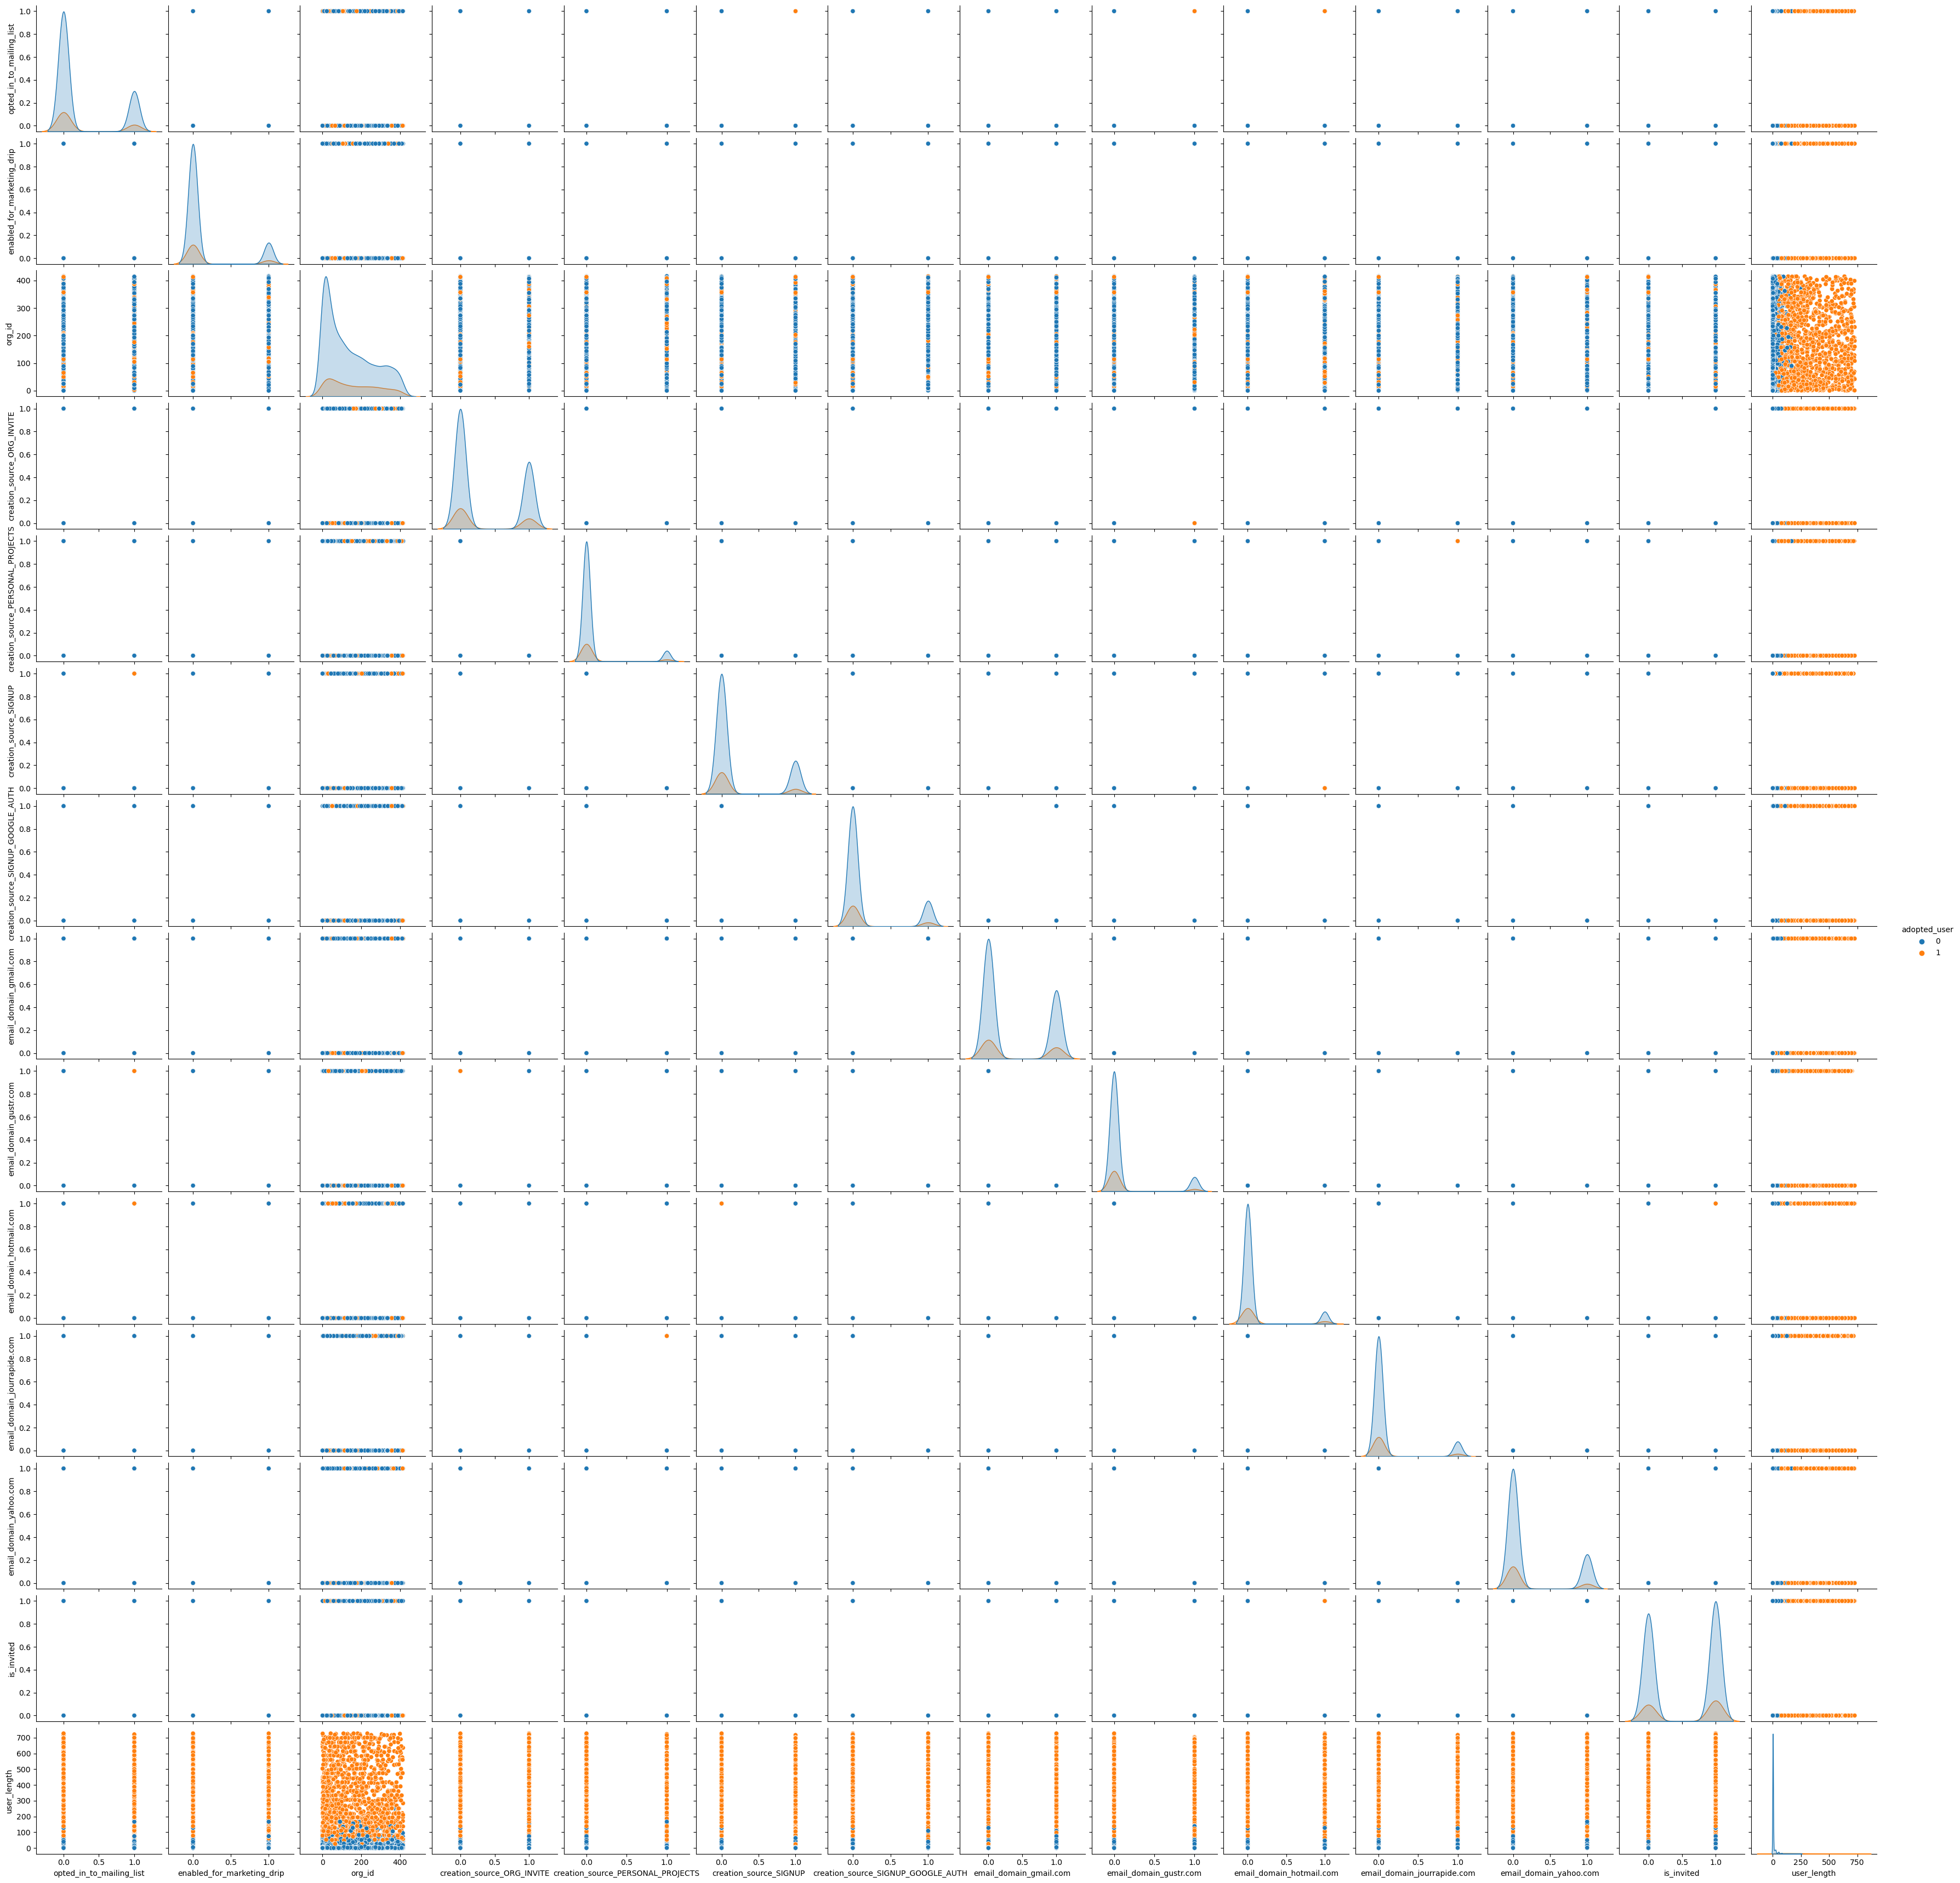

In [63]:
sns.pairplot(df_model, hue ='adopted_user')
plt.show()

In [64]:
df_model.describe().T

,count,mean,std,min,25%,50%,75%,max
opted_in_to_mailing_list,8012.0,0.252746,0.434614,0.0,0.0,0.0,1.0,1.0
enabled_for_marketing_drip,8012.0,0.151398,0.358459,0.0,0.0,0.0,0.0,1.0
org_id,8012.0,142.544933,124.228888,0.0,30.0,109.0,239.0,416.0
adopted_user,8012.0,0.180354,0.384506,0.0,0.0,0.0,0.0,1.0
creation_source_ORG_INVITE,8012.0,0.354219,0.478306,0.0,0.0,0.0,1.0,1.0
creation_source_PERSONAL_PROJECTS,8012.0,0.084623,0.278337,0.0,0.0,0.0,0.0,1.0
creation_source_SIGNUP,8012.0,0.210434,0.407643,0.0,0.0,0.0,0.0,1.0
creation_source_SIGNUP_GOOGLE_AUTH,8012.0,0.172866,0.378155,0.0,0.0,0.0,0.0,1.0
email_domain_gmail.com,8012.0,0.365701,0.481656,0.0,0.0,0.0,1.0,1.0
email_domain_gustr.com,8012.0,0.105092,0.306692,0.0,0.0,0.0,0.0,1.0


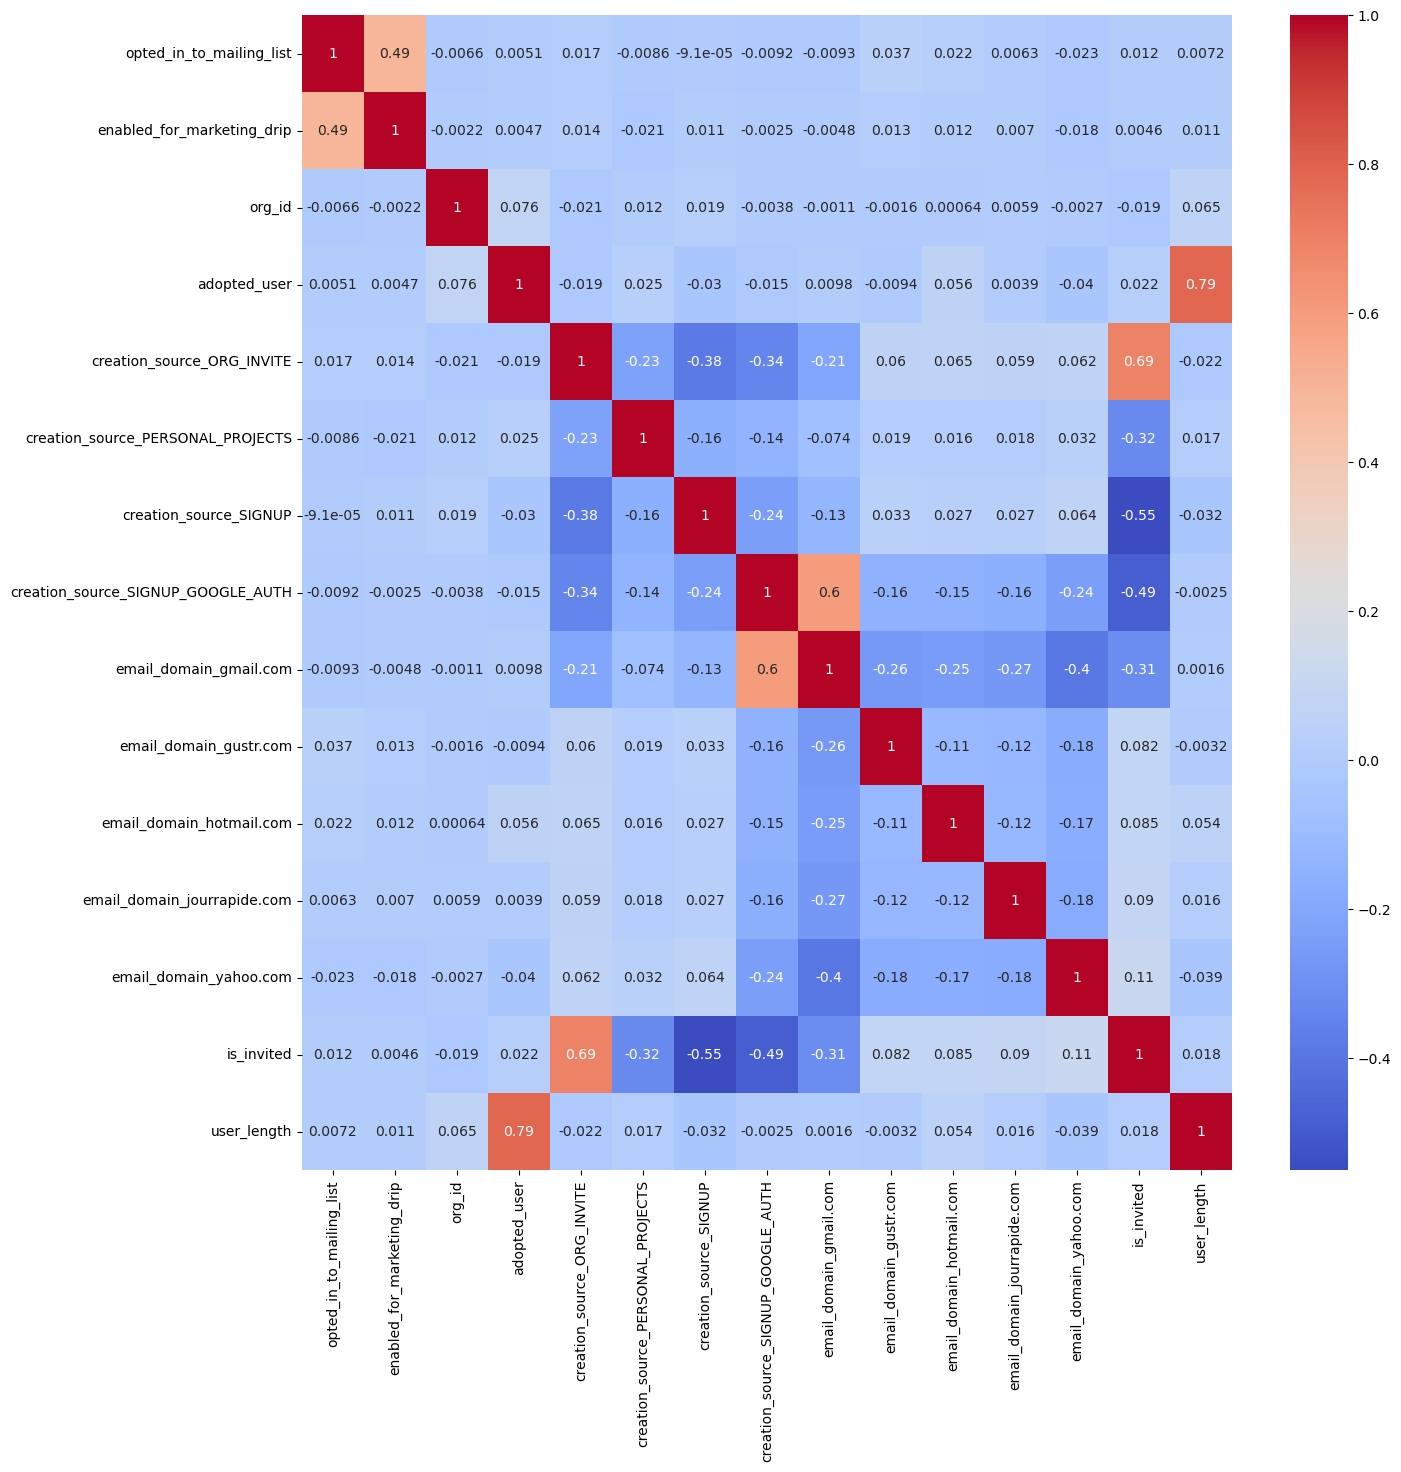

In [65]:
plt.figure(figsize=(15,15))
sns.heatmap(df_model.corr(), annot=True, cmap='coolwarm')
plt.show()

Comment: From the graphs we can see that user_length is strongly correlated with adopted user. Both ['is_invited'] with ['creation_source_SIGNUP_GOOGLE_AUTH'] and ['opted_in_to_mailing_list'] with ['enabled_for_marketing_drip'] are suffering from collinearity.

In [66]:
df_model.corr().T

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,email_domain_gmail.com,email_domain_gustr.com,email_domain_hotmail.com,email_domain_jourrapide.com,email_domain_yahoo.com,is_invited,user_length
opted_in_to_mailing_list,1.000000,0.493909,-0.006558,0.005066,0.016638,-0.008628,-0.000091,-0.009155,-0.009270,0.036700,0.022040,0.006260,-0.023220,0.011825,0.007150
enabled_for_marketing_drip,0.493909,1.000000,-0.002217,0.004737,0.014075,-0.020829,0.010886,-0.002474,-0.004769,0.013084,0.012091,0.007023,-0.018052,0.004599,0.011258
org_id,-0.006558,-0.002217,1.000000,0.075502,-0.020784,0.012117,0.018821,-0.003759,-0.001107,-0.001556,0.000644,0.005852,-0.002712,-0.019285,0.065316
adopted_user,0.005066,0.004737,0.075502,1.000000,-0.018900,0.025333,-0.030325,-0.015274,0.009815,-0.009377,0.056402,0.003884,-0.039711,0.022217,0.787366
creation_source_ORG_INVITE,0.016638,0.014075,-0.020784,-0.018900,1.000000,-0.225184,-0.382347,-0.338579,-0.208533,0.060203,0.064796,0.059355,0.061965,0.694533,-0.022221
creation_source_PERSONAL_PROJECTS,-0.008628,-0.020829,0.012117,0.025333,-0.225184,1.000000,-0.156967,-0.138999,-0.074439,0.018641,0.016498,0.017583,0.031569,-0.324223,0.016953
creation_source_SIGNUP,-0.000091,0.010886,0.018821,-0.030325,-0.382347,-0.156967,1.000000,-0.236010,-0.129424,0.032764,0.026533,0.026583,0.063897,-0.550509,-0.031571
creation_source_SIGNUP_GOOGLE_AUTH,-0.009155,-0.002474,-0.003759,-0.015274,-0.338579,-0.138999,-0.236010,1.000000,0.602074,-0.156662,-0.152576,-0.160891,-0.239552,-0.487491,-0.002520
email_domain_gmail.com,-0.009270,-0.004769,-0.001107,0.009815,-0.208533,-0.074439,-0.129424,0.602074,1.000000,-0.260203,-0.253418,-0.267228,-0.397878,-0.309016,0.001605
email_domain_gustr.com,0.036700,0.013084,-0.001556,-0.009377,0.060203,0.018641,0.032764,-0.156662,-0.260203,1.000000,-0.114371,-0.120604,-0.179568,0.081559,-0.003205


In [67]:
x = df_model.drop(['adopted_user'] , axis = 1 )
y = df_model['adopted_user']

In [60]:
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()

#x = pd.DataFrame(scaler.fit_transform(x), columns = scaler.get_feature_names_out())
#x

In [68]:
x_train,x_test, y_train,y_test = train_test_split(x,y,test_size = 0.3)

In [69]:
xgbc = XGBClassifier(learning_rate = 0.1, scale_pos_weight = 7 ,max_depth = 7,
                     use_label_encoder=False
                    )

xgbc.fit(x_train, y_train)

xgbc_y_pred = xgbc.predict(x_test)

xgbc_acc = accuracy_score(y_test, xgbc_y_pred)

cv_scores_xbgc = cross_val_score(xgbc,x_train,y_train, cv=5)

print('\nXGB Y accuracy: ',xgbc_acc)
print('XGB Y predicted: ',xgbc_y_pred)
print(f'\nThe confusion matrix:\n{confusion_matrix(y_test,xgbc_y_pred)}')
print(f'\n{classification_report(y_test,xgbc_y_pred)}')
print(f'\nAccuracy of each cross validation: ',cv_scores_xbgc)
print(f'\nAverage 5-Fold CV Score: {np.mean(cv_scores_xbgc)}')
print(f'\nThe sd {cv_scores_xbgc.std()}')

[22:08:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:08:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:08:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:08:55] WARNING: /Users/runner/miniforge3/cond

In [70]:
rf1 = RandomForestClassifier(class_weight = 'balanced_subsample' ,n_estimators = 1000)

rf1.fit(x_train,y_train)

y_predrf1 = rf1.predict(x_test)

cv_scoresrf = cross_val_score(rf1,x_train,y_train, cv=5)

rf1_acc = accuracy_score(y_test, y_predrf1)

print('\nrandom forest Y accuracy: ',rf1_acc)
print('random forest Y predicted: ',y_predrf1)
print(f'\nThe confusion matrix: \n{confusion_matrix(y_test,y_predrf1)}')
print(f'\n{classification_report(y_test, y_predrf1)}')
print(f'\nAccuracy of each cross validation: ',cv_scoresrf)
print(f'\nAverage 5-Fold CV Score RandomForestClassifier: {np.mean(cv_scoresrf):.5f}')
print(f'\nThe sd {cv_scoresrf.std()}')


importances = pd.Series(data=rf1.feature_importances_,
                        index= x_train.columns)

importances.sort_values(ascending = False)


random forest Y accuracy:  0.9608985024958403
random forest Y predicted:  [0 0 1 ... 0 0 0]

The confusion matrix: 
[[1947   36]
 [  58  363]]

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1983
           1       0.91      0.86      0.89       421

    accuracy                           0.96      2404
   macro avg       0.94      0.92      0.93      2404
weighted avg       0.96      0.96      0.96      2404


Accuracy of each cross validation:  [0.96524064 0.95811052 0.96256684 0.95361285 0.96520963]

Average 5-Fold CV Score RandomForestClassifier: 0.96095

The sd 0.004495881612233745


user_length                           0.877433
org_id                                0.081585
opted_in_to_mailing_list              0.005836
enabled_for_marketing_drip            0.004629
creation_source_ORG_INVITE            0.004467
email_domain_gmail.com                0.004398
email_domain_hotmail.com              0.004120
email_domain_yahoo.com                0.003287
email_domain_jourrapide.com           0.002802
creation_source_SIGNUP                0.002735
is_invited                            0.002662
email_domain_gustr.com                0.002541
creation_source_PERSONAL_PROJECTS     0.002125
creation_source_SIGNUP_GOOGLE_AUTH    0.001379
dtype: float64

### 2a) Methodology

When it comes to a binary classification problem, Random Forest Classifer and XGBOOST Classifer primarily perform best. In this project, I modelled both algorithms with the below features
Feature set:
- opted_in_to_mailing_list
- enabled_for_marketing_drip
- org_id
- creation_source_GUEST_INVITE 
- creation_source_ORG_INVITE
- creation_source_PERSONAL_PROJECTS
- creation_source_SIGNUP
- creation_source_SIGNUP_GOOGLE_AUTH
- cuvox.de
- gmail.com 
- gustr.com
- hotmail.com
- jourrapide.com
- is_invited
- user_length

Where creation_source_ are one hot encoded from original creation_source, and same with each email domains. 
<br>**is_invited** is a mapped column where 1 = is_invited by an existing user, 0 = self-registered. 
<br>**user_length** is an aggregated column from last_session_creation_time - creation_time
<br>
<br>By using the predictors above, I was able to achieve a high accuracy score with low type I and type II error. However, the tradeoff is that XG Booster Classifier has a lower type II error and higher type I error. This indicates that it works well on predicting the adopted users, but there are more non-adopted users that are wrongly classified as adopted user. If the goal of the team is to accurately predict the adopted users, then I recommend using XG Boost Classifer as the final model since it contains a lower type II error and has a lower standard deviation on cross-validation scores. This also indicates that the variability of each performance is stable. At the same time, adjusting the parameter scale_pos_weight allows us to control the unbalanced weight in our target variable. Further, setting the eta (learning rate) its shrinkage step sized used in update to prevent overfitting. After each boosting step, we can directly obtain the weights of new features. Eta shrinks the feature weights to make the boosting process more conservative. On the other hand, the Random Forest Classifier has a higher accuracy and cross validation average than XG Boost Classifier, but it contains higher type II error, meaning that more adopted users are wrongly classified as non-adopted uses. Moreover, with a higher standard deviation in cross validation scores, the model is less stable on performance, but if the team is aiming for a high accuracy, I would recommend Random Forest Classifier. Similar to the XG Boost Classifier, Here, I also adjusted the weight of the target variables by setting the class_weight = balance_subsample, meaning the algorithms will use the values to target and automatically adjust weights inversely proportional to class frequencies in the input data. The weights are also computed based on the bootstrap sample for every tree grown. Since each tree formed in Random Forest are i.i.d by setting n_estimators = 1000, it will ensure that the individual errors of trees are minimized and the overall variance and error is reduced. 
<br>
<br>Personally, I would prefer using XG Boosting Classifier despite the accuracy being slightly lower; however, I am more concerned that the adopted users being correctly classified. If there is a specific advertising plan or strategy specifically for adopted users, then the ones that were incorrectly being classified as adopted user have a higher chance turning into adopted users after experiencing the special strategy. This would thus increase the adoption rate.

### 3) What Factors Predict User Adoption?

These are the ways in which I would use feature selection:
- Use my intuition to decide which feature has a correlation to our output.
- Authenticate the correlation between feature to ensure avoiding multicollinearity.
- Run an OLS regression and check each feature’s significance level and coefficients.
- Run a Random Forest and retrieve the feature importance.

<br>
<br>In the simple OLS regression and feature importance table below, we can see user_length is the most significant feature in all 16 features; it has a high t value(meaning the coefficient of user_length is not equals 0), and having a extreme p_value satisfies any confidence level. From the correlation graph above, it is seen that user_length is highly correlated with our target-adopted user, and it is not suffering from multicollinearity. The last thing we must consider is since the correlation between user_length and adopted user are so high, does it come from the target? Observing this further, it becomes known that the longer a user has been using the platform, the higher probability that a user will log in three separate days within 7 days. I returned to the dataset and discovered that there are still many users who have been with the platform for a while but have yet to become an adopted user. Therefore, user-Length can be our first feature. Secondly, the column, org_id is also a good feature even though the importance level and correlation between adopted user and org_id are not high. Still, according to the regression table, org_id has a high t value and the same p_value as user_length, which means that org_id is a significant feature to our target. At the same time, it makes sense that some organizations tend to have more communication and tasks involved with the frequency in which they log in to increase becoming an adopted user. The following features are being selected as the similar reasons:
- ['gmail.com', 'hotmail.com' ,'is_invited' , 'creation_source_PERSONAL_PROJECTS', 'creation_source_GUEST_INVITE' , 'creation_source_SIGNUP']
<br>
<br>After this, the feature ['opted_in_to_mailing_list'] and ['enabled_for_marketing_drip'] are having a high correlation between each other, which leading might leads to multicollinearity so I will choose one as that is little more significant which is ['enabled_for_marketing_drip'].
<br>
<br> In conclusion the final features are：

- **user_length** 
- **org_id**
- **gmail.com** 
- **hotmail.com**
- **is_invited** 
- **creation_source_PERSONAL_PROJECTS**
- **creation_source_GUEST_INVITE** 
- **creation_source_SIGNUP**
- **enabled_for_marketing_drip**

In [71]:
importances = pd.Series(data=rf1.feature_importances_,
                        index= x_train.columns)

importances.sort_values(ascending = False)

user_length                           0.877433
org_id                                0.081585
opted_in_to_mailing_list              0.005836
enabled_for_marketing_drip            0.004629
creation_source_ORG_INVITE            0.004467
email_domain_gmail.com                0.004398
email_domain_hotmail.com              0.004120
email_domain_yahoo.com                0.003287
email_domain_jourrapide.com           0.002802
creation_source_SIGNUP                0.002735
is_invited                            0.002662
email_domain_gustr.com                0.002541
creation_source_PERSONAL_PROJECTS     0.002125
creation_source_SIGNUP_GOOGLE_AUTH    0.001379
dtype: float64

In [72]:
import statsmodels.api as sm

model = sm.OLS(y, x).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           adopted_user   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     1011.
Date:                Tue, 14 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:09:23   Log-Likelihood:                 184.17
No. Observations:                8012   AIC:                            -340.3
Df Residuals:                    7998   BIC:                            -242.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
opte

In [73]:
df_model_final = df_model

In [75]:
df_model_final = df_model_final[['user_length','org_id','is_invited','creation_source_PERSONAL_PROJECTS','creation_source_SIGNUP','enabled_for_marketing_drip','adopted_user']]

### Now I will redo the model with the selected features plus using make_classification technics to see if we can have a better accuracy

When I first graph with the Learning curve I got long flat tail and it may suggest that the algorithm is learning too fast and we may benefit from slowing it down. So I set the eta = 0.05, and now the new curve looks much better.

The final model with XG Boost Classifier after the feature selection achieved a highest accuracy of 97%, the confusion matrix now has a even lower typeII and type I error.

In [76]:
x2, y2 = make_classification(n_features=50, n_samples=10000, n_informative=50, n_redundant=0, random_state = 99)

x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.3, random_state = 99)

xgbc2 = XGBClassifier(n_estimators=2000, eta = 0.05, min_child_weight = 9, max_depth = 4 ,subsample=0.5)

eval_set = [(x_train2, y_train2), (x_test2,y_test2)]

xgbc2.fit(x_train2, y_train2, eval_set=eval_set,verbose = 0)

predxgbc2 = xgbc2.predict(x_test2)

cv_scoresxgb2 = cross_val_score(xgbc2,x_train2,y_train2, cv=5)

[22:09:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:31] WARNING: /Users/runner/miniforge3/cond

In [77]:
print(f'Accuracy: {accuracy_score(y_test2, predxgbc2):.5f}')
print(f'\nThe confusion matrix: \n{confusion_matrix(y_test2,predxgbc2)}')
print(f'\n{classification_report(y_test2, predxgbc2)}')
print(f'\nAccuracy of each cross validation: ',cv_scoresxgb2)
print(f'\nAverage 5-Fold CV Score XG Boost Classifier: {np.mean(cv_scoresxgb2):.5f}')
print("\nThe sd {}".format(cv_scoresxgb2.std()))

Accuracy: 0.96767

The confusion matrix: 
[[1461   45]
 [  52 1442]]

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1506
           1       0.97      0.97      0.97      1494

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000


Accuracy of each cross validation:  [0.95928571 0.96142857 0.95357143 0.95642857 0.965     ]

Average 5-Fold CV Score XG Boost Classifier: 0.95914

The sd 0.003948649988881478


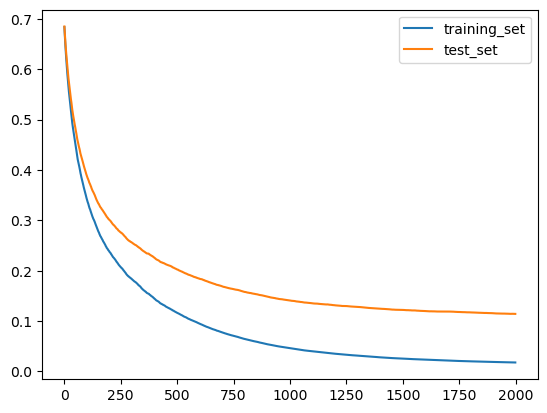

In [78]:
plot = xgbc2.evals_result()

plt.plot(plot['validation_0']['logloss'], label='training_set')
plt.plot(plot['validation_1']['logloss'], label='test_set')
plt.legend()
plt.show()

### 4) Additional Commentary (Optional)

However, since the model has **user_length** as our feature, it isn't useful to predict a new user's label, given that the user_length for new users is always 0.

## Thanks.

**Haitong(Felix) Huang**
<br>**Email: Felixhht0106@gmail.com**
<br>**Linkedin: www.linkedin.com/in/felixhuang-data**
<br>**github: https://github.com/FHFelix?tab=repositories**